# General Regression Explanations

This notebook shows how to produce general regression explanations with general SHAP values.

In this example, we ask what distinguishes towns with above-average house price. Suppose we have a sample of towns which our model predicts has above-average house prices. We can ask why our model expects the distribution of house prices in our sample resembles the distribution of house prices in towns with above-average house prices.

We find that the most distinctive features of towns with above-average house prices are average number of rooms per dwelling (RM) and percent of 'low status' population (LSTAT).

This question is a specific example of a general question. Define a set of 'positive density functions' $P$ and a set of 'negative density functions' $N$. For a single observation $x$, we can ask why our model predicts it comes from a positive density rather than a negative density. For a sample of observations $X$, we can ask what features best distinguish observations which follow positive densities from observations which follow negative densities.

Here, the positive density is the distribution of house prices in towns with above-average house prices. The negative density is the distribution of house prices in all towns.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.probability_distance import ProbabilityDistance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.kernel_ridge import KernelRidge

We begin by loading the Boston dataset and training our regressor.

In [2]:
boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = KernelRidge(alpha=1.)
reg.fit(X_train, y_train)
print('Test score: % .4f' % reg.score(X_test, y_test))

Test score:  0.6937


Next, we estimate the kernel density of the target variable (median house price) of our background (training) dataset.

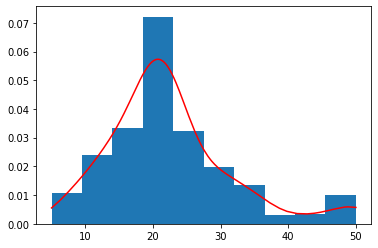

In [3]:
kde_all = KernelDensity(bandwidth=3)
kde_all.fit(y_train.reshape(-1,1))
y_train_sorted = np.sort(y_train)
log_dens = kde_all.score_samples(y_train_sorted.reshape(-1,1))

fig, ax = plt.subplots(1,1)
ax.hist(y_train, density=True)
ax.plot(y_train_sorted, np.exp(log_dens), color='red')
plt.show()

We repeat the exercise for towns with above-average house prices.

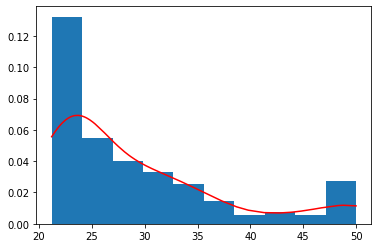

In [4]:
median = np.quantile(y_train, .5)
y_train_q1 = y_train[y_train > median]
kde_q1 = KernelDensity(bandwidth=3)
kde_q1.fit(y_train_q1.reshape(-1,1))
y_train_q1_sorted = np.sort(y_train_q1)
log_dens = kde_q1.score_samples(y_train_q1_sorted.reshape(-1,1))

fig, ax = plt.subplots(1,1)
ax.hist(y_train_q1, density=True)
ax.plot(y_train_q1_sorted, np.exp(log_dens), color='red')
plt.show()

Next, we sample observations for explanation. We select observations our model predicts have above-average house prices.

Features 5 and 12 (RM and LSTAT) are the most important features. We can visualize where our observations fall along these dimensions in a scatterplot. The selected observations are highlighted in red.

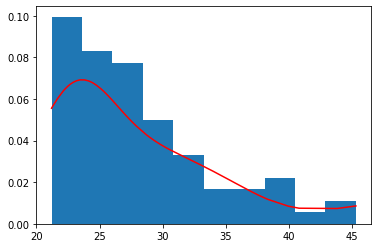

In [5]:
y_pred = reg.predict(X_test)
y_pred_q1 = y_pred[y_pred > median]
x = X_test[y_pred > median]
y_pred_q1_sorted = np.sort(y_pred_q1)
log_dens = kde_q1.score_samples(y_pred_q1_sorted.reshape(-1,1))

fix, ax = plt.subplots(1,1)
ax.hist(y_pred_q1, density=True)
ax.plot(y_pred_q1_sorted, np.exp(log_dens), color='red')
plt.show()

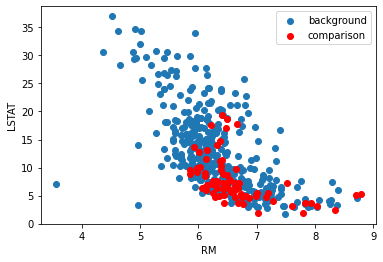

In [6]:
plt.scatter(X_train[:,5], X_train[:,12], label='background')
plt.scatter(x[:,5], x[:,12], c='red', label='comparison')
plt.xlabel(boston.feature_names[5])
plt.ylabel(boston.feature_names[12])
plt.legend()
plt.show()

Compute the G-SHAP values, where $g$ is `ProbabilityDistance`. `ProbabilityDistance` measures the probability that each observation in our sample $x$ was generated by a positive density, rather than a negative density.

Here, the positive density is the density of house prices in towns with above-average house prices (as estimated by `kde_q1`). The negative density is the density of house prices in all towns in the background dataset (as estimated by `kde_all`).

In [7]:
pos_density = lambda x: np.exp(kde_q1.score_samples(x.reshape(-1,1)))
neg_density = lambda x: np.exp(kde_all.score_samples(x.reshape(-1,1)))
g = ProbabilityDistance(pos_density, neg_density)
explainer = gshap.KernelExplainer(reg.predict, X_train, g)
x = X_test[y_pred > median]
gshap_values = explainer.gshap_values(x, nsamples=200)

For interpretation, we compare our sample to the background dataset in terms of $g$. We see that there is a near-100% chance our sample was generated by the positive density, as opposed to the negative density. In other words, our model correctly identifies that our sample was drawn from a population of towns with above-average house prices. By contrast, there is a near-0% chance the background data was generated by the positive density, rather than the negative density.

The sum of the G-SHAP values should approximately equal the difference between our sample and the background data (allowing for sampling error).

In [8]:
g_comparison, g_background = explainer.compare(x, bootstrap_samples=10000)
print('Probability that our sample follows the positive density: %.4f' % g_comparison)
print('Probability that the background data follows the positive density: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Probability that our sample follows the positive density: 1.0000
Probability that the background data follows the positive density: 0.0002
Sum of G-SHAP values: 0.8872


Finally, we plot our results. This plot tells us which features distinguish towns with above-average house prices.

More precisely, our model predictions that our sample is 100% more likely to have been drawn from a population of towns with above-average house prices, compared with samples drawn from a population of all towns. Each G-SHAP value $\phi_j$ is the number of percentage points explained by feature $j$.

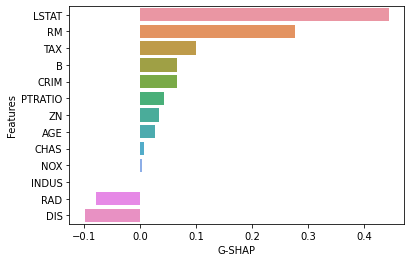

In [9]:
df = pd.DataFrame({
    'Features': list(boston.feature_names),
    'G-SHAP': list(gshap_values),
}).sort_values('G-SHAP', ascending=False)
sns.barplot(x='G-SHAP', y='Features', data=df)
plt.show()